# Tokenizer
Se define como longitud mínima de término 3 y longitud máxima 20. En primer instancia, cualquier cadena de caracteres pertenecientes al alfabeto español (*a-z*, contando las vocales con tilde, la *ñ* y la *u* con diéresis) se tomará como token. Ya que no se realizará un preprocesamiento de los documentos, se discriminarán mayúsculas y minúsculas; i.e. Papa, papa y papá serán palabras distintas. Sin embargo, al momento de sacar las palabras vacías, para no extender innecesariamente la lista, la comparación con los tokens se realiza transformando el token en minúsculas.

In [ ]:
from tokenizer_main import main

main("../datos-prueba/test/", stopword_filename="./aux-files/stop-word-list-es.txt", no_extract=True)

# Extraer términos especiales
Para la extracción de "no palabras", se tiene en cuenta que las expresiones regulares utilizadas *generan términos extra*. Esto no es necesariamente algo negativo, ya que puede que una dirección de correo, teléfono o abreviatura esté mal escrita, y porque composiciones extrañas como *1,200.48,29* son de interés por no ser conocidas. Se extraen, en orden:

## URLs y direcciones de correo electrónico
Para las direcciones de correo electrónico, se define el siguiente patrón (la parte cursiva significa opcional):

(caracteres que no sean espacios) Arroba (letras) Punto (de 1 a 3 letras) *punto (de 1 a 2 letras)*

Para las direcciones web, se define el siguiente patrón que cumple con la especificación RFC5892:

*(protocolo de la forma XXXX://)* (dominio específico y/o www.; letras, puntos y guiones) punto (dominio más alto; solo letras) *dos puntos (número de puerto) (nombre de recurso, parámetros adicionales y anclas; cualquier caracter menos espacios precedido por barra, signo de pregunta o numeral, respectivamente)*

## Números
Se extraen números que representan dinero, porcentajes y fechas (con formato de 1 a 4 números, empezando o terminando por el año, dividido por barras o guiones) con sus respectivos símbolos. También se extraen números telefónicos en los 4 formatos de la ITU-T E.164. Finalmente se extraen cantidades (números seguidos de abreviaturas de hasta dos letras y un punto) y números genéricos (que no estén precedidos por cosas que no sean números).

## Nombres propios
Se considera nombre propio aquél que está compuesto por dos o más palabras que empiezan con mayúscula y siguen con mayúsculas y minúsculas. Este método tiene la desventaja de considerar nombres propios a palabras que están totalmente en mayúsculas.

## Abreviaturas tal cual están escritas: S.A., Dr., Lic.
Para esto, se siguen las siguientes reglas para todas las palabras terminadas en punto:
    - Si después del punto hay una minúscula, coma o punto y coma, es una abreviación.
    - Si la palabra vuelve a aparecer en el documento sin el punto final, no es abreviación. Sino sí lo es.
    - Si la palabra aparece más de dos veces, es una abreviación.
   
   
Cuando un término especial se extrae del documento también se lo elimina, de forma que no aparezca en la lista de términos producida por la búsqueda de palabras genéricas (punto 1).

In [ ]:
from tokenizer_main import main

main("../datos-prueba/test/", stopword_filename="./aux-files/stop-word-list-es.txt", no_extract=False)

# Colección T12012-qm
Para trabajar correctamente con la colección T12012-qm, es necesario agregar reglas especiales al tokenizer:
    - Nombres químicos, como moléculas (H20), símbolos de los elementos (Ar)
    - Temperaturas que pueden ser negativas y estar en Farenheit, Celsius o Kelvin
    - Abreviaciones para algunas fórmulas como la densidad (g/mL)
    - Fórmulas químicas del formato (moléculas o partículas separadas por signo más) signo igual signo mayor (moléculas o partículas separadas por signo más)
    - Configuraciones electrónicas (1s2 2s2 p2, 2 pxμ 2 pyμ 2 pz)
    - Caracteres especiales utilizados en química, como el de longitud de enlace (Å)

# Stemming
Al correr nuevamente el proceso de *stemming*, la cantidad de términos se redujo a casi la mitad: de 26825 a 11761. El largo promedio de término disminuyó de 8 a 6. Los términos únicos se redujeron de 15067 a 4902.
Se puede notar que muchos términos fueron agrupados por tener la misma raíz, a costo de perder la semántica de estos. Además, es necesario actualizar el archivo de palabras vacías para que refleje los stems de estas, de manera que no sean los términos con mayor frecuencia.

Distinta raíz, mismo stem:
    - pasa (de uva), pase (de pelota) = pas
    - salir, salado = sal
    - comunica, común, comunidad = comun

Distinto stem, misma raíz:
    - pelota = pelot, pelotazo = pelotaz
    - año = año, años = años
    - gobierno = gobiern, gobernador = gobern

In [ ]:
from tokenizer_main import main

main("../datos-prueba/test/", stopword_filename="./aux-files/stop-word-list-es.txt", stemming="snowball")

# Porter y Lancaster
Se definen las mismas métricas que en el ejercicio de Tokenizer:

| Métrica | Porter | Lancaster |
| --- | --- | --- |
| Cantidad de tokens | 147945 | 147945 |
| Cantidad de términos | 6685 | 5646 |
| Largo promedio de token | 6,44 | 5,77 |
| Cantidad de términos únicos | 2767 | 2303 |

En general, el algoritmo de Porter acorta en menor medida los términos que el de Lancaster y por eso resulta en más términos generados. Por un lado, menos términos permite una mayor eficiencia en el índice, pero se es más propenso a obtener el mismo stem para dos términos que son conceptualmente distintos (overstemming). Por ejemplo, Lancaster recorta *library*, *libraries* y *libre* a **libr**, mientras que Porter distingue a *library* y *libraries* como **librari** y a *libre* como **libr**.

In [ ]:
from tokenizer_main import main

# Porter stemming
main("../datos-prueba/cisi/", stemming="porter", stopword_filename="./aux-files/stop-word-list-en.txt")
# Lancaster stemming
main("../datos-prueba/cisi/", stemming="lancaster", stopword_filename="./aux-files/stop-word-list-en.txt")

# Identificación del lenguaje
La detección de lenguaje utilizada se basa en un diccionario común para todos los lenguajes. En este caso, se redujo el diccionario a los caracteres ingleses (*a* a *z*). Para la comparación, se obtuvo la frecuencia relativa de los caracteres en los archivos de entrenamiento, y se calculó la correlación de Pearson con las frecuencias relativas de las líneas del archivo de Testing. Para los unigramas, se obtuvo un porcentaje de éxito de 87,3%. Para los bigramas, se obtuvo un porcentaje de éxito de 94,7%. Para el módulo *langdetect* de PyPI se obtuvo un porcentaje de éxito de aproximadamente 99% (según la documentación, el algoritmo es no determinístico).
Cabe destacar que los algoritmos propios (tanto unigramas como bigramas) tuvieron un índice de correlación significativamente más bajo que la probabilidad de *langdetect*, y este índice varía enormemente (erró en índices de correlación de 0,99, y acertó en 0,26). Además, para *langdetect*, las identificaciones erróneas tienen una probabilidad muy baja. 

In [ ]:
from langdetect_main import main, pypi_langdetect
# Unigramas
main("languagedetect/languageIdentificationData", "unigram", True)

# Bigramas
main("languagedetect/languageIdentificationData", "bigram", True)

# PyPI-langdetect
pypi_langdetect("languagedetect/languageIdentificationData")

# Verificación de la Ley de Zipf
Para la extracción de términos, se van a quitar palabras vacías y extraer palabras especiales, según los puntos definidos arriba.

In [ ]:
from tokenizer_main import main

main("../datos-prueba/quijote/", stopword_filename="./aux-files/stop-word-list-es.txt", no_extract=False)

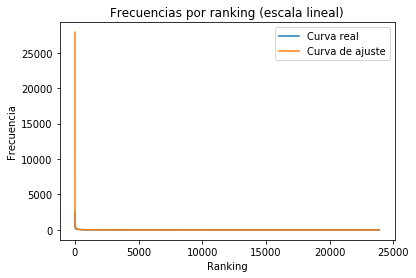

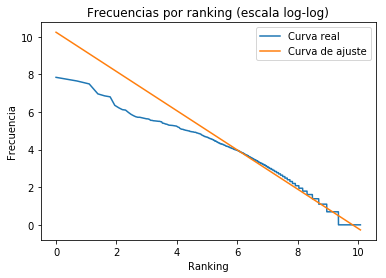

In [10]:
import csv
import numpy as np
from matplotlib import pyplot as plt

frequencies = []
with open("results/tokenizer/terminos.txt", "r") as file:
    reader = csv.DictReader(file, delimiter="\t")
    for row in reader:
        frequencies.append(int(row["CF"]))

x = range(1, len(frequencies)+1)
y = frequencies

log_x = np.log(x)
log_y = np.log(y)

# Coeficients of the adjusted degree 1 polynomial
coeficients = np.polyfit(log_x, log_y, 1)
# Adjusted curve
adjusted_curve = np.poly1d(coeficients)
# f(x) values for the adjusted curve
log_y_pred = adjusted_curve(log_x)
# f(x) values for lineal scale
y_pred = [np.exp(y) for y in log_y_pred]

plt.title("Frecuencias por ranking (escala lineal)")
plt.xlabel("Ranking")
plt.ylabel("Frecuencia")
plt.plot(x, y, x, y_pred)
plt.legend(("Curva real", "Curva de ajuste"), loc="upper right")
plt.show()

plt.title("Frecuencias por ranking (escala log-log)")
plt.xlabel("Ranking")
plt.ylabel("Frecuencia")
plt.plot(log_x, log_y, log_x, log_y_pred)
plt.legend(("Curva real", "Curva de ajuste"), loc="upper right")
plt.show()

Lo más importante para destacar es la incidencia de la cola de la curva, que sesga la curva de ajuste enormemente (distribuciones de cola pesada).
Se procede a eliminar la cabeza y la cola (se decide recortar un 0,05% de los rankings).

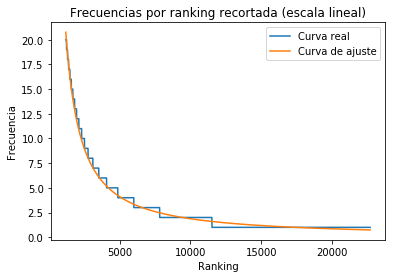

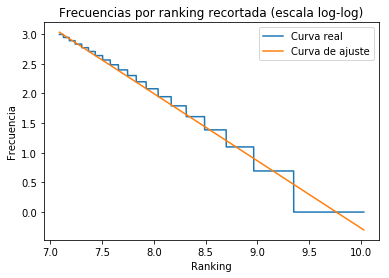

In [11]:
starting_index = int(len(x)*0.05)
ending_index = int(len(x) - len(x)*0.05)

log_x_cut = log_x[starting_index:ending_index]
log_y_cut = log_y[starting_index:ending_index]
x_cut = x[starting_index:ending_index]
y_cut = y[starting_index:ending_index]

# Adjust again
coeficients_cut = np.polyfit(log_x_cut, log_y_cut, 1)
# Adjusted curve
adjusted_curve_cut = np.poly1d(coeficients_cut)
# f(x) values for the adjusted curve
log_y_pred_cut = adjusted_curve_cut(log_x_cut)
# f(x) values for lineal scale
y_pred_cut = [np.exp(y) for y in log_y_pred_cut]

plt.title("Frecuencias por ranking recortada (escala lineal)")
plt.xlabel("Ranking")
plt.ylabel("Frecuencia")
plt.plot(x_cut, y_cut, x_cut, y_pred_cut)
plt.legend(("Curva real", "Curva de ajuste"), loc="upper right")
plt.show()

plt.title("Frecuencias por ranking recortada (escala log-log)")
plt.xlabel("Ranking")
plt.ylabel("Frecuencia")
plt.plot(log_x_cut, log_y_cut, log_x_cut, log_y_pred_cut)
plt.legend(("Curva real", "Curva de ajuste"), loc="upper right")
plt.show()

Con los extremos recortados, la curva de ajuste tiene menos error en cuanto a la distribución real.

# Predicción de términos con cierta frecuencia utilizando Zipf
A continuación se calculará la cantidad de términos que tienen frecuencias 100, 1000 y 10000. Para esto, si en la curva de ajuste que predice la frecuencia según el ranking, despejamos el ranking:

$$ r = (f - c) / m $$

donde *r* es el ranking, *f* la frecuencia, *c* el coeficiente de grado 0 de la curva y *m* el coeficiente de grado 1.

Además, si se calcula el ranking del término de frecuencia *x* y el ranking del término de frecuencia *x-1*, la diferencia es aproximadamente la cantidad de términos de frecuencia *x* (si un término se predice en el ranking 1,5 con 100 de frecuencia y el término con 99 de frecuencia se predice en el ranking 3, tendremos $ 3 - 1,5 = 1,5 $, o aproximadamente 2 términos con 100 de frecuencia

In [25]:
m = coeficients[0]
c = coeficients[1]

def ranking_by_frequency(f, c=c, m=m):
    # Our adjusted curve is represented in log-log scale, so we have to scale the lineal frequency received
    f = np.log(f)
    # Then, scale the result back to lineal
    return np.exp((f - c) / m)

def terms_with_frequency(f):
    rank_x = ranking_by_frequency(f)
    # Next in ranking
    rank_next = ranking_by_frequency(f-1)
    print("Predicted rank of term with frequency " + str(f) + ": " + str(rank_x))
    print("Predicted rank of term with frequency " + str(f-1) + ": " + str(rank_next))
    print("Predicted terms with frequency " + str(f) + ": " + str(rank_next - rank_x))
    
f_list = [100, 1000, 10000]
for f in f_list:
    terms_with_frequency(f)

Predicted rank of term with frequency 100: 222.15411837733916
Predicted rank of term with frequency 99: 224.30708785583
Predicted terms with frequency 100: 2.1529694784908315
Predicted rank of term with frequency 1000: 24.379089645842804
Predicted rank of term with frequency 999: 24.402507665037337
Predicted terms with frequency 1000: 0.023418019194533457
Predicted rank of term with frequency 10000: 2.675349961104591
Predicted rank of term with frequency 9999: 2.6756067227127294
Predicted terms with frequency 10000: 0.0002567616081385893


Se obtiene que los términos con frecuencia 100 son 2 y que no existen términos con frecuencias 1000 o 10000.

In [28]:
def real_terms_with_frequency(frequencies, f):
    i = 0
    count = 0
    while frequencies[i] >= f:
        if (frequencies[i] == f):
            count += 1
        i += 1
    return count

for f in f_list:
    print("Real terms with frequency " + str(f) + ": " + str(real_terms_with_frequency(frequencies, f)))

Real terms with frequency 100: 2
Real terms with frequency 1000: 0
Real terms with frequency 10000: 0


A pesar de la aproximación, los resultados predichos son correctos.

# Ley de Heaps

In [6]:
# Get token list
from utilities.file_lister import file_lister
from utilities.file_to_string import file_to_string
from tokenizer.tokenizer import tokenizar

lista_tokens = []
for document in file_lister("../datos-prueba/cisi/"):
    lista_tokens.extend(tokenizar(file_to_string(document)))

In [10]:
# Get (total_words, unique_words) pairs
vocabulary = {}
total_words = []
unique_words = []
for words_processed, word in enumerate(lista_tokens):
    if word not in vocabulary:
        # One more unique word added to vocabulary
        vocabulary[word] = 1
    # Add one because index starts at 0
    total_words.append(words_processed + 1)
    unique_words.append(len(vocabulary))

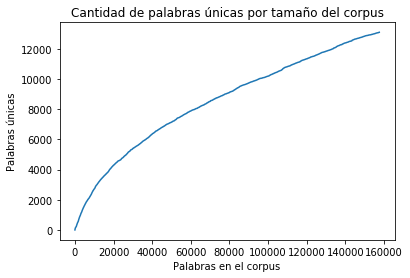

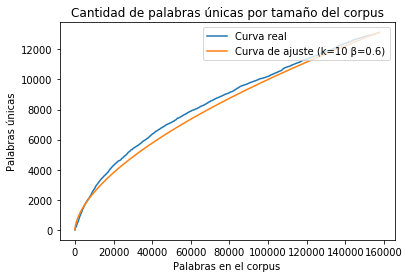

In [29]:
import numpy as np
from matplotlib import pyplot as plt

# Plot Heaps' law
plt.title("Cantidad de palabras únicas por tamaño del corpus")
plt.xlabel("Palabras en el corpus")
plt.ylabel("Palabras únicas")
plt.plot(total_words, unique_words)
plt.show()

def calculate_heaps(total_words, unique_words, k, beta):
    y_pred = []
    for text_size in range(1, len(total_words) + 1):
        y_pred.append(k * text_size ** beta)
    return y_pred

def mean_square_error(v_y, v_yi):
    sum = 0
    for index in range(len(v_y)):
        sum += (v_y[index] - v_yi[index])**2
    return sum / len(v_y)

final_k = 10
final_beta = 0.3
y_pred = calculate_heaps(total_words, unique_words, k*10, beta/20)
mse = mean_square_error(unique_words, y_pred)
# k from 10 to 100
for k in range(1, 10+1):
    # β from 0,30 to 0,70
    for beta in range(3, 24+1):
        y_pred_aux = calculate_heaps(total_words, unique_words, k*10, beta/20)
        mse_aux = mean_square_error(unique_words, y_pred_aux)
        if mse_aux < mse:
            y_pred = y_pred_aux
            mse = mse_aux
            final_k = k*10
            final_beta = beta/20
        
plt.title("Cantidad de palabras únicas por tamaño del corpus")
plt.xlabel("Palabras en el corpus")
plt.ylabel("Palabras únicas")
plt.plot(total_words, unique_words, total_words, y_pred)
plt.legend(("Curva real", "Curva de ajuste (k=" + str(final_k) + " β=" + str(final_beta) + ")"), loc="upper right")
plt.show()

Utilizando como métrica de comparación el error cuadrado medio (mse) se obtiene con algunas pruebas rápidas que, si se varía *k* entre 10 y 100 en intervalos de 10 y a *β* entre 0,3 y 0,7 en intervalos de 0,05, el mejor ajuste se obtiene con valores de $k = 10$ y $β = 0,6$.